**Load all the features saved as numpy array**

In [ ]:
# Load the pre-extracted image features and question embeddings.
# This retrieves the saved feature arrays from the previous steps.
# Loading these features allows us to proceed with model training without re-extracting them.

train_features = np.load("train_features.npy")  # (num_train_samples, 2048)
val_features = np.load("val_features.npy")  # (num_val_samples, 2048)

map image feature for each question row to get the same sampled dataset

In [ ]:
# Map image features to each question row based on image ID.
# This ensures that each question in the filtered DataFrames is associated with its corresponding image features.
# It handles cases where the order of questions might not match the order of extracted image features.

#Load features from filtered image IDs
train_image_features = dict(zip(df_train_filtered['image_id'], train_features)) # Create a dictionary for train features
val_image_features = dict(zip(df_val_filtered['image_id'], val_features)) # Create a dictionary for val features

# Function to get the image feature for each question row
def get_image_features_for_questions(df, image_features_dict):
    image_features = []
    for img_id in df['image_id']:
        image_features.append(image_features_dict.get(img_id, np.zeros(2048)))  # Default to zero if missing
    return np.array(image_features)

# Get the image features for the filtered train and val question rows
train_image_features_for_questions = get_image_features_for_questions(df_train_filtered, train_image_features)
val_image_features_for_questions = get_image_features_for_questions(df_val_filtered, val_image_features)

# Print out the shapes to confirm they match the number of rows
print(f"Train Image Features Shape: {train_image_features_for_questions.shape}")
print(f"Val Image Features Shape: {val_image_features_for_questions.shape}")

Train Image Features Shape: (53389, 2048)
Val Image Features Shape: (26769, 2048)


In [ ]:
train_question_embeddings = np.load("bert_embeddings_train.npy")  # (num_train_samples, 768)
train_answers = np.load("train_answers.npy")

In [ ]:
val_question_embeddings = np.load("bert_embeddings_val.npy")  # (num_val_samples, 768)
val_answers = np.load("val_answers.npy")  # (num_val_samples, 181)

# Model Architectures and training


**Approach 2: Gated Fusion Network**

Model Architecture Description (Approach 2):

The Gated Fusion Network aims to improve upon simple concatenation by learning the importance of each input modality. It first projects both image and text features to a common lower-dimensional space (512). Then, it employs a gating mechanism, using sigmoid activation, to produce weights for each modality's projection. These weights are applied through element-wise multiplication, effectively scaling the importance of each feature. The gated features are then fused by element-wise addition, followed by a deeper fully connected network with residual connections. The residual connection helps in training deeper networks by allowing gradients to flow more easily. Finally, a softmax output layer provides the probability distribution over the answer classes.

Hyperparameters Tuned (Approach 2):

Learning Rate: Set to 0.0001 for the Adam optimizer.
Number of Epochs: Set to 15.
Batch Size: Set to 32.
Projection Dimension: Image and text features are projected to 512 dimensions. This common dimension allows for meaningful fusion.
Number of Units in Dense Layers: The fully connected layers after fusion also use 512 units.
Dropout Rate: Set to 0.3 in the Dropout layers after the first and second fully connected blocks.

In [ ]:
X_train_text = train_question_embeddings  # Shape: (num_train_samples, 768)
X_train_image = train_image_features_for_questions  # Shape: (num_train_samples, 2048)

X_val_text = val_question_embeddings
X_val_image = val_image_features_for_questions  # Shape: (num_val_samples, 2048)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ img_projection (Dense)    │ (None, 512)            │      1,049,088 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_projection (Dense)   │ (None, 512)            │        393,728 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gate_img (Dense)          │ (None, 512)            │        262,656 │ img_projection[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gate_text (Dense)         │ (None, 512)            │        262,656 │ text_projection[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gated_img (Multiply)      │ (None, 512)            │              0 │ img_projection[0][0],  │
│                           │                        │                │ gate_img[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gated_text (Multiply)     │ (None, 512)            │              0 │ text_projection[0][0], │
│                           │                        │                │ gate_text[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fused_features (Add)      │ (None, 512)            │              0 │ gated_img[0][0],       │
│                           │                        │                │ gated_text[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc1 (Dense)               │ (None, 512)            │        262,656 │ fused_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop1 (Dropout)           │ (None, 512)            │              0 │ fc1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc2 (Dense)               │ (None, 512)            │        262,656 │ drop1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual (Add)            │ (None, 512)            │              0 │ fc2[0][0], drop1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop2 (Dropout)           │ (None, 512)            │              0 │ residual[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 181)            │         92,853 │ drop2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,586,293 (9.87 MB)

 Trainable params: 2,586,293 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3202 - loss: 2.7865 - val_accuracy: 0.4335 - val_loss: 1.8974
Epoch 2/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4235 - loss: 1.9005 - val_accuracy: 0.4584 - val_loss: 1.6454
Epoch 3/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4585 - loss: 1.6712 - val_accuracy: 0.4986 - val_loss: 1.5062
Epoch 4/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4846 - loss: 1.5547 - val_accuracy: 0.5091 - val_loss: 1.4377
Epoch 5/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5048 - loss: 1.4675 - val_accuracy: 0.5271 - val_loss: 1.3820
Epoch 6/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5146 - loss: 1.4147 - val_accuracy: 0.5370 - val_loss: 1.3452
Epoch 7/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5263 - loss: 1.3655 - val_accuracy: 0.5344 - val_loss: 1.3268
Epoch 8/15
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5390 - loss: 1.3

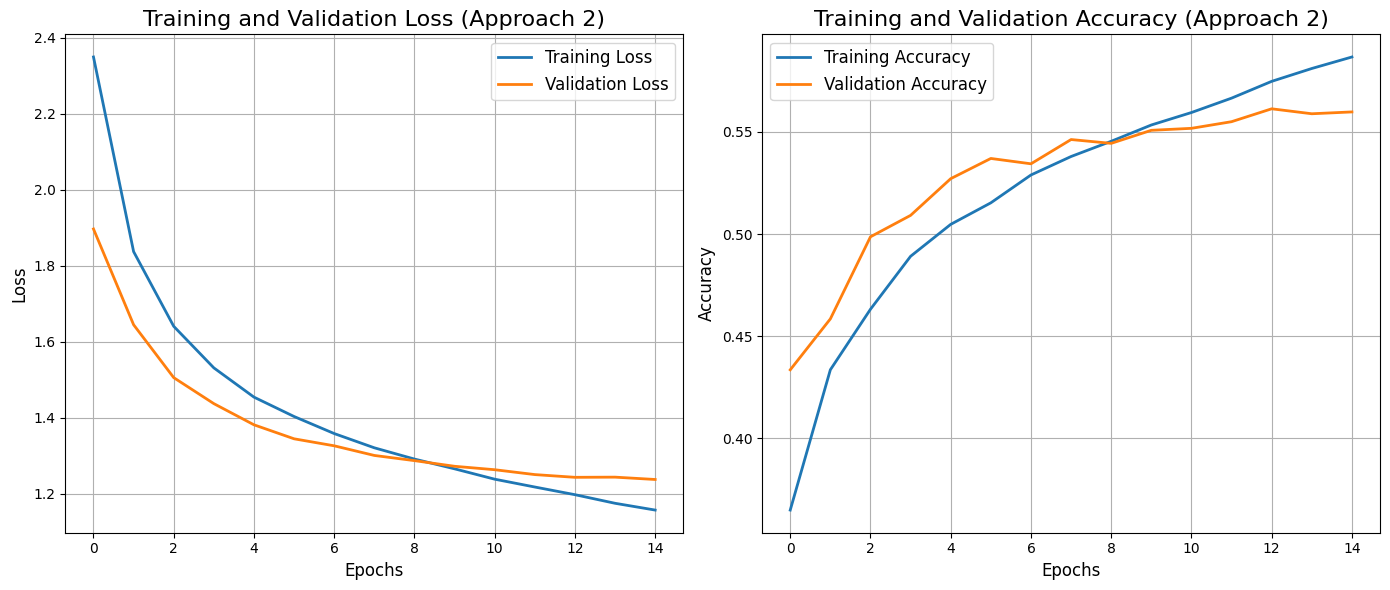

837/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5583 - loss: 1.2369

Approach 2 Validation Loss: 1.2382
Approach 2 Validation Accuracy: 0.5598


In [ ]:
# Define and train a Gated Fusion Network model.
# This model projects image and text features to a common dimension and uses a gating mechanism.
# The gating allows the model to learn the importance of each modality before fusion, followed by deeper layers with residual connections.

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, Add, Multiply, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Number of answer classes (from your encoding, e.g., 181)
num_classes = 181

# Define input layers for image and text features
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(768,), name="text_input")

# Project image features to a common hidden dimension (e.g., 512)
img_proj = Dense(512, activation='relu', name="img_projection")(image_input)
# Project text features to the same hidden dimension
text_proj = Dense(512, activation='relu', name="text_projection")(text_input)

# Gating mechanism for each modality
gate_img = Dense(512, activation='sigmoid', name="gate_img")(img_proj)
gate_text = Dense(512, activation='sigmoid', name="gate_text")(text_proj)

# Apply gating (element-wise multiplication)
gated_img = Multiply(name="gated_img")([img_proj, gate_img])
gated_text = Multiply(name="gated_text")([text_proj, gate_text])

# Fuse the modalities by adding the gated features
fused_features = Add(name="fused_features")([gated_img, gated_text])

# Build a deeper fully connected network with residual connections

# First FC block
fc1 = Dense(512, activation='relu', name="fc1")(fused_features)
drop1 = Dropout(0.3, name="drop1")(fc1)

# Second FC block
fc2 = Dense(512, activation='relu', name="fc2")(drop1)
# Residual connection: add output of first block (drop1) to fc2 output
residual = Add(name="residual")([fc2, drop1])
drop2 = Dropout(0.3, name="drop2")(residual)

# Output layer
output = Dense(num_classes, activation='softmax', name="output")(drop2)

# Define the model
model_approach2 = Model(inputs=[image_input, text_input], outputs=output)
model_approach2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
model_approach2.summary()

history_approach2 = model_approach2.fit(
    x = [X_train_image, X_train_text],  # Note: the order should match the Input layers order (image then text)
    y = train_answers,  # One-hot encoded answers
    validation_data = ([X_val_image, X_val_text], val_answers),
    epochs = 15,
    batch_size = 32,
    verbose = 1
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach2.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach2.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Approach 2)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach2.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach2.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Approach 2)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
val_loss_approach2, val_accuracy_approach2 = model_approach2.evaluate([X_val_image, X_val_text], val_answers, verbose=1)
print(f'\nApproach 2 Validation Loss: {val_loss_approach2:.4f}')
print(f'Approach 2 Validation Accuracy: {val_accuracy_approach2:.4f}')

## **Tuned model for the second approach**

Tuned Changes Summary
- Fusion Strategy: Switched from Add → Concatenate → Preserves richer modality distinctions
- Dropout: Reduced from 0.5 → 0.3 → Lower regularization pressure
- Residual Connections:  Added → Improves gradient flow
- Batch Normalization:  Added → Helps normalize activations
- Learning Rate Scheduling:  Added → Improves late-stage generalization
- Top-3 Accuracy:  Tracked top_3_accuracy → Captures near-miss predictions

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Multiply, Add, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# Set hyperparameters
dropout_rate = 0.3
hidden_dim = 1024
num_classes = 181

# Inputs
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(768,), name="text_input")

# Projections
img_proj = Dense(hidden_dim, activation='relu', name="img_projection")(image_input)
text_proj = Dense(hidden_dim, activation='relu', name="text_projection")(text_input)

# Gating
gate_img = Dense(hidden_dim, activation='sigmoid', name="gate_img")(img_proj)
gate_text = Dense(hidden_dim, activation='sigmoid', name="gate_text")(text_proj)

gated_img = Multiply(name="gated_img")([img_proj, gate_img])
gated_text = Multiply(name="gated_text")([text_proj, gate_text])

# Fuse (concatenation instead of Add)
fused = Add(name="fused_features")([gated_img, gated_text])  # Shape: (batch, 512)

# FC block 1
fc1 = Dense(512, activation='relu')(fused)
fc1 = Dropout(0.2)(fc1)

# FC block 2 with residual
fc2 = Dense(512, activation='relu')(fc1)
residual = Add()([fc2, fc1])
residual = Dropout(0.2)(residual)

# Output layer
output = Dense(num_classes, activation='softmax', name="output")(residual)

# Model definition
model_approach2 = Model(inputs=[image_input, text_input], outputs=output)

# Compile
model_approach2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train
history_approach2 = model_approach2.fit(
    x=[X_train_image, X_train_text],
    y=train_answers,
    validation_data=([X_val_image, X_val_text], val_answers),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3257 - loss: 2.8156 - top_3_accuracy: 0.5949 - val_accuracy: 0.4436 - val_loss: 1.8710 - val_top_3_accuracy: 0.7345 - learning_rate: 1.0000e-04
Epoch 2/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4291 - loss: 1.8553 - top_3_accuracy: 0.7403 - val_accuracy: 0.4850 - val_loss: 1.6195 - val_top_3_accuracy: 0.7795 - learning_rate: 1.0000e-04
Epoch 3/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4727 - loss: 1.6424 - top_3_accuracy: 0.7768 - val_accuracy: 0.5058 - val_loss: 1.4964 - val_top_3_accuracy: 0.8109 - learning_rate: 1.0000e-04
Epoch 4/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4892 - loss: 1.5307 - top_3_accuracy: 0.8009 - val_accuracy: 0.5181 - val_loss: 1.4258 - val_top_3_accuracy: 0.8219 - learning_rate: 1.0000e-04
Epoch 5/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5130 - loss: 1.4483 - top_3_accuracy: 0.8177 - val_accuracy: 0.5269 - val_loss: 1.3871 - val

In [ ]:
# Evaluate
val_loss_2, val_acc_2, val_top3_2 = model_approach2.evaluate([X_val_image, X_val_text], val_answers, verbose=1)
print(f"\nApproach 2 Validation Accuracy: {val_acc_2:.4f}")
print(f"Approach 2 Top-3 Accuracy: {val_top3_2:.4f}")
print(f'Approach 2 Validation Loss: {val_loss_2:.4f}')

837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5666 - loss: 1.2275 - top_3_accuracy: 0.8616

Approach 2 Validation Accuracy: 0.5668
Approach 2 Top-3 Accuracy: 0.8615

Approach 2 Validation Loss: 1.2278


In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach2.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach2.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Approach 2)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach2.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach2.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Approach 2)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()